In [ ]:
import torch
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.multi_objective import qExpectedHypervolumeImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import GenericMCObjective

class CustomQNEHVI(AcquisitionFunction):
    def __init__(self, model, best_f, sampler, objective, **kwargs):
        super().__init__(model=model)
        self.best_f = best_f
        self.sampler = sampler
        self.objective = objective
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Use the GP to predict y_1
        with torch.no_grad():
            posterior = self.model(X)
            y_1_pred = posterior.mean

        # Calculate y_2 using your custom formula
        y_2_pred = self.calculate_y_2(X)

        # Apply the custom logic: You want to maximize y_1 and minimize y_2
        # You can concatenate or combine these in a way similar to qNEHVI.
        # Here, we use a simple approach: the output will be the difference between y_1 and y_2.
        combined_output = y_1_pred - y_2_pred  # This is a simple placeholder for a more complex strategy
        
        # Now, apply Monte Carlo sampling to estimate the acquisition function
        samples = self.sampler.sample_posterior(self.model, X, num_samples=128)

        # Evaluate the acquisition function: this is where you would use hypervolume improvement
        # For simplicity, we assume it's just the mean improvement here
        return combined_output.mean(dim=0)

    def calculate_y_2(self, X: torch.Tensor):
        # Calculate y_2 based on the deterministic cost function (your custom logic)
        # For example, if y_2 = sum of X features:
        return X.sum(dim=-1)

# Now create a GP model and fit it on the data (just like qNEHVI)
train_X = torch.rand(10, 3)  # Example input (10 samples, 3 input features)
train_Y = torch.randn(10, 2)  # Example output (10 samples, 2 outputs: y_1, y_2)

model = SingleTaskGP(train_X, train_Y[:, 0:1])  # Only use y_1 for the GP

# Define the best observed value for y_1 (for EI)
best_f = train_Y[:, 0:1].max()  # Best observed value of y_1

# Define the sampler
sampler = SobolQMCNormalSampler()

# Define the objective function for the acquisition function
objective = GenericMCObjective(lambda samples, X=None: samples[..., 0])  # Maximize y_1

# Create the custom QNEHVI acquisition function
acqf = CustomQNEHVI(
    model=model,
    best_f=best_f,
    sampler=sampler,
    objective=objective
)

# Now optimize the acquisition function
bounds = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])  # Define input bounds

# Optimize the acquisition function using `optimize_acqf`
candidates, acq_value = optimize_acqf(
    acq_function=acqf,
    bounds=bounds,
    q=1,  # Number of candidates per iteration
    num_restarts=10,
    raw_samples=512,
)

print(candidates)


C:\Users\danin\AppData\Local\Temp\ipykernel_41504\2326322282.py:46: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(train_X, train_Y[:, 0:1])  # Only use y_1 for the GP


TypeError: MCSampler.__init__() missing 1 required positional argument: 'sample_shape'

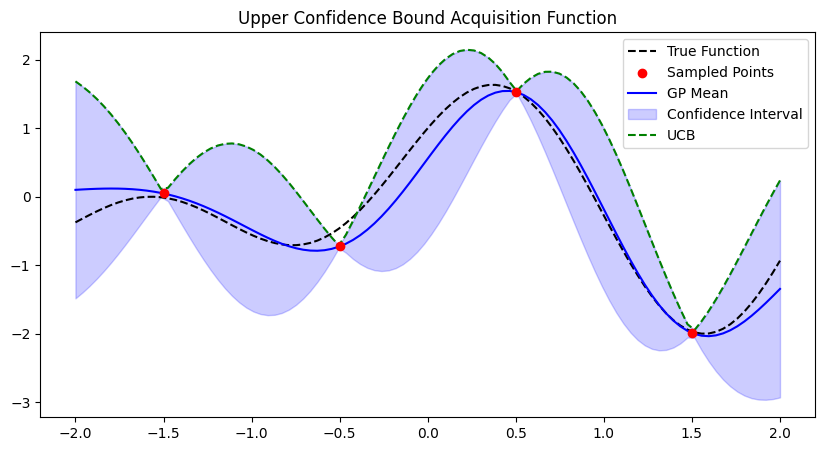

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def objective_function(x):
    """Simulated objective function (noisy sine wave)."""
    return np.sin(3 * x) + np.cos(2 * x) + np.random.normal(0, 0.1, size=x.shape)

def gaussian_process(x, X_samples, Y_samples, length_scale=0.5, noise=1e-6):
    "   ""Simple Gaussian Process with RBF kernel."""
    kernel = lambda a, b: np.exp(-0.5 * np.subtract.outer(a, b) ** 2 / length_scale**2)
    K = kernel(X_samples, X_samples) + noise * np.eye(len(X_samples))
    K_s = kernel(x, X_samples)
    K_ss = kernel(x, x) + 1e-8 * np.eye(len(x))
    
    K_inv = np.linalg.inv(K)
    mu_s = K_s @ K_inv @ Y_samples
    cov_s = K_ss - K_s @ K_inv @ K_s.T
    sigma_s = np.sqrt(np.diag(cov_s))
    
    return mu_s, sigma_s

def upper_confidence_bound(mu, sigma, beta=2.0):
    """Computes the UCB acquisition function values."""
    return mu + beta * sigma

# Define search space
X = np.linspace(-2, 2, 100)

# Sample some points
X_samples = np.array([-1.5, -0.5, 0.5, 1.5])
Y_samples = objective_function(X_samples)

# Compute GP predictions
mu, sigma = gaussian_process(X, X_samples, Y_samples)

# Compute UCB values
UCB = upper_confidence_bound(mu, sigma)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(X, np.sin(3 * X) + np.cos(2 * X), 'k--', label='True Function')
plt.scatter(X_samples, Y_samples, color='red', zorder=3, label='Sampled Points')
plt.plot(X, mu, 'b', label='GP Mean')
plt.fill_between(X, mu - 2 * sigma, mu + 2 * sigma, color='blue', alpha=0.2, label='Confidence Interval')
plt.plot(X, UCB, 'g--', label='UCB')
plt.legend()
plt.title("Upper Confidence Bound Acquisition Function")
plt.show()
